In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.baseline import Baseline

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)


import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import LabelEncoder
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE_MUSCLES,
    PARTICIPANT,
    INDEPENDENT_FEATURES
)

numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [9]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
patient_code = train["patient_code"].values

In [19]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    print('σ', σ.shape)
    print('FVC_est', FVC_est.shape)
    print('α', α.shape)
    print('α[patient_code]', α[patient_code].shape)
    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

In [20]:
from jax import random

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

σ ()
FVC_est (1549,)
α (176,)
α[patient_code] (1549,)
σ ()
FVC_est (1549,)
α (176,)
α[patient_code] (1549,)


  0%|          | 0/4000 [00:00<?, ?it/s]

σ ()
FVC_est (1549,)
α (176,)
α[patient_code] (1549,)


sample: 100%|██████████| 4000/4000 [00:53<00:00, 74.20it/s, 63 steps of size 1.00e-02. acc. prob=0.84]  


#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)
df, encoder_dict = data.build()

2023-03-07 16:05:07,541 - hb_mep.data_access.core - INFO - Reading data ....
2023-03-07 16:05:07,549 - hb_mep.data_access.core - INFO - Processing data ...
2023-03-07 16:05:07,623 - hb_mep.utils.utils - INFO - func:build took: 0.08 sec


In [5]:
df.head()

,intensity,AUC_Biceps,AUC_ECR,participant,ch_combination,raw_AUC_Biceps,raw_AUC_ECR
0,0.0,0.0999,0.101,0,0,9.990000e-09,1.010000e-08
1,0.2,0.1390,0.125,0,0,1.390000e-08,1.250000e-08
2,0.4,0.1080,0.114,0,0,1.080000e-08,1.140000e-08
3,0.6,0.1140,0.121,0,0,1.140000e-08,1.210000e-08
4,0.8,0.1260,0.119,0,0,1.260000e-08,1.190000e-08


In [53]:
# response = df[RESPONSE_MUSCLES].apply(list, axis=1).to_numpy().reshape(-1,)
response = df[RESPONSE_MUSCLES].to_numpy()
participant = df[PARTICIPANT].to_numpy().reshape(-1,)
independent = df[INDEPENDENT_FEATURES].to_numpy().reshape(-1,)
intensity = df[INTENSITY].to_numpy().reshape(-1,)

In [95]:
def model(intensity, participant, independent, response_obs=None):
    a_Biceps_level_scale_global_scale = numpyro.sample('a_Biceps_global_scale', dist.HalfNormal(2.0))
    a_Biceps_level_mean_global_scale = numpyro.sample('a_Biceps_level_mean_global_scale', dist.HalfNormal(5.0))

    b_Biceps_level_mean_global_scale = numpyro.sample('b_Biceps_level_mean_global_scale', dist.HalfNormal(5.0))
    b_Biceps_level_scale_global_scale = numpyro.sample('b_Biceps_global_scale', dist.HalfNormal(2.0))

    sigma_Biceps_offset_level_scale_global_scale = \
        numpyro.sample('sigma_Biceps_offset_level_scale_global_scale', dist.HalfCauchy(5.0))
    sigma_Biceps_slope_level_scale_global_scale = \
        numpyro.sample('sigma_Biceps_slope_level_scale_global_scale', dist.HalfCauchy(5.0))

    a_ECR_level_scale_global_scale = numpyro.sample('a_ECR_global_scale', dist.HalfNormal(2.0))
    a_ECR_level_mean_global_scale = numpyro.sample('a_ECR_level_mean_global_scale', dist.HalfNormal(5.0))

    b_ECR_level_mean_global_scale = numpyro.sample('b_ECR_level_mean_global_scale', dist.HalfNormal(5.0))
    b_ECR_level_scale_global_scale = numpyro.sample('b_ECR_global_scale', dist.HalfNormal(2.0))

    sigma_ECR_offset_level_scale_global_scale = \
        numpyro.sample('sigma_ECR_offset_level_scale_global_scale', dist.HalfCauchy(5.0))
    sigma_ECR_slope_level_scale_global_scale = \
        numpyro.sample('sigma_ECR_slope_level_scale_global_scale', dist.HalfCauchy(5.0))

    n_participants = np.unique(participant).shape[0]
    n_levels = np.unique(independent).shape[0]

    with numpyro.plate("n_levels", n_levels, dim=-2):
        a_Biceps_level_mean = numpyro.sample("a_Biceps_level_mean", dist.HalfNormal(a_Biceps_level_mean_global_scale))
        b_Biceps_level_mean = numpyro.sample("b_Biceps_level_mean", dist.HalfNormal(b_Biceps_level_mean_global_scale))

        a_Biceps_level_scale = numpyro.sample("a_Biceps_level_scale", dist.HalfNormal(a_Biceps_level_scale_global_scale))
        b_Biceps_level_scale = numpyro.sample("b_Biceps_level_scale", dist.HalfNormal(b_Biceps_level_scale_global_scale))

        sigma_Biceps_offset_level_scale = \
            numpyro.sample(
                'sigma_Biceps_offset_level_scale',
                dist.HalfCauchy(sigma_Biceps_offset_level_scale_global_scale)
            )
        sigma_Biceps_slope_level_scale = \
            numpyro.sample(
                'sigma_Biceps_slope_level_scale',
                dist.HalfCauchy(sigma_Biceps_slope_level_scale_global_scale)
            )

        a_ECR_level_mean = numpyro.sample("a_ECR_level_mean", dist.HalfNormal(a_ECR_level_mean_global_scale))
        b_ECR_level_mean = numpyro.sample("b_ECR_level_mean", dist.HalfNormal(b_ECR_level_mean_global_scale))

        a_ECR_level_scale = numpyro.sample("a_ECR_level_scale", dist.HalfNormal(a_ECR_level_scale_global_scale))
        b_ECR_level_scale = numpyro.sample("b_ECR_level_scale", dist.HalfNormal(b_ECR_level_scale_global_scale))

        sigma_ECR_offset_level_scale = \
            numpyro.sample(
                'sigma_ECR_offset_level_scale',
                dist.HalfCauchy(sigma_ECR_offset_level_scale_global_scale)
            )
        sigma_ECR_slope_level_scale = \
            numpyro.sample(
                'sigma_ECR_slope_level_scale',
                dist.HalfCauchy(sigma_ECR_slope_level_scale_global_scale)
            )

        with numpyro.plate("n_participants", n_participants, dim=-1):
            a_Biceps = numpyro.sample("a_Biceps", dist.Normal(a_Biceps_level_mean, a_Biceps_level_scale))
            b_Biceps = numpyro.sample("b_Biceps", dist.Normal(b_Biceps_level_mean, b_Biceps_level_scale))

            a_ECR = numpyro.sample("a_ECR", dist.Normal(a_ECR_level_mean, a_ECR_level_scale))
            b_ECR = numpyro.sample("b_ECR", dist.Normal(b_ECR_level_mean, b_ECR_level_scale))

            sigma_Biceps_offset = numpyro.sample('sigma_Biceps_offset', dist.HalfCauchy(sigma_Biceps_offset_level_scale))
            sigma_Biceps_slope = numpyro.sample('sigma_Biceps_slope', dist.HalfCauchy(sigma_Biceps_slope_level_scale))

            sigma_ECR_offset = numpyro.sample('sigma_ECR_offset', dist.HalfCauchy(sigma_ECR_offset_level_scale))
            sigma_ECR_slope = numpyro.sample('sigma_ECR_slope', dist.HalfCauchy(sigma_ECR_slope_level_scale))

    mean_Biceps = jax.nn.relu(b_Biceps[independent, participant] * (intensity - a_Biceps[independent, participant]))
    sigma_Biceps = sigma_Biceps_offset[independent, participant] + sigma_Biceps_slope[independent, participant] 

    mean_ECR = jax.nn.relu(b_ECR[independent, participant] * (intensity - a_ECR[independent, participant]))
    sigma_ECR = sigma_ECR_offset[independent, participant] + sigma_ECR_slope[independent, participant] 

    mean = jnp.array(jnp.array([mean_Biceps, mean_ECR])).T
    # cov = jnp.diag(jnp.array([sigma_Biceps, sigma_ECR]))
    cov = jnp.tile(jnp.diag(jnp.array([sigma_Biceps, sigma_ECR])), (180, 1, 1))

    print('response_obs', response_obs.shape)
    print('mean', mean.shape)
    print('cov', cov.shape)
    print('sigma_Biceps', sigma_Biceps.shape)
    print('mean_ECR', mean_ECR.shape)
    with numpyro.plate("data", len(intensity)):
        return numpyro.sample("obs", dist.MultivariateNormal(mean, cov), obs=response_obs)
# numpyro.render_model(model, model_args=(intensity, participant, independent, response))

In [94]:
jnp.tile(jnp.diag(jnp.array([1, 2])), (180, 1, 1))

(180, 2, 2)

In [96]:
# MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, **config.MCMC_PARAMS)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, intensity, participant, independent, response)
posterior_samples = mcmc.get_samples()

response_obs (180, 2)
mean (180, 2)
cov (180, 1, 2)
sigma_Biceps (180,)
mean_ECR (180,)
response_obs (180, 2)
mean (180, 2)
cov (180, 1, 2)
sigma_Biceps (180,)
mean_ECR (180,)


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

response_obs (180, 2)
mean (180, 2)
cov (180, 1, 2)
sigma_Biceps (180,)
mean_ECR (180,)


In [97]:
mcmc.print_summary()


                                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
                                 a_Biceps[0,0]     -0.76      1.05     -0.74     -1.87      0.30      2.00  63819.22
                                 a_Biceps[1,0]     -0.87      0.83     -1.06     -1.77      0.42      2.00  14109.46
                                 a_Biceps[2,0]     -0.00      1.27     -0.18     -1.60      1.95      2.00  17717.04
                                 a_Biceps[3,0]     -0.03      0.87     -0.12     -1.14      1.28      2.00  22206.53
                                 a_Biceps[4,0]     -0.08      1.10     -0.25     -1.16      1.32      2.00  32955.67
                         a_Biceps_global_scale      2.11      1.55      2.24      0.22      3.76       nan 9286525.33
                      a_Biceps_level_mean[0,0]      2.62      1.86      2.48      0.14      5.35      2.00  21656.18
                      a_Biceps_level_mean[1,0]      1.50      

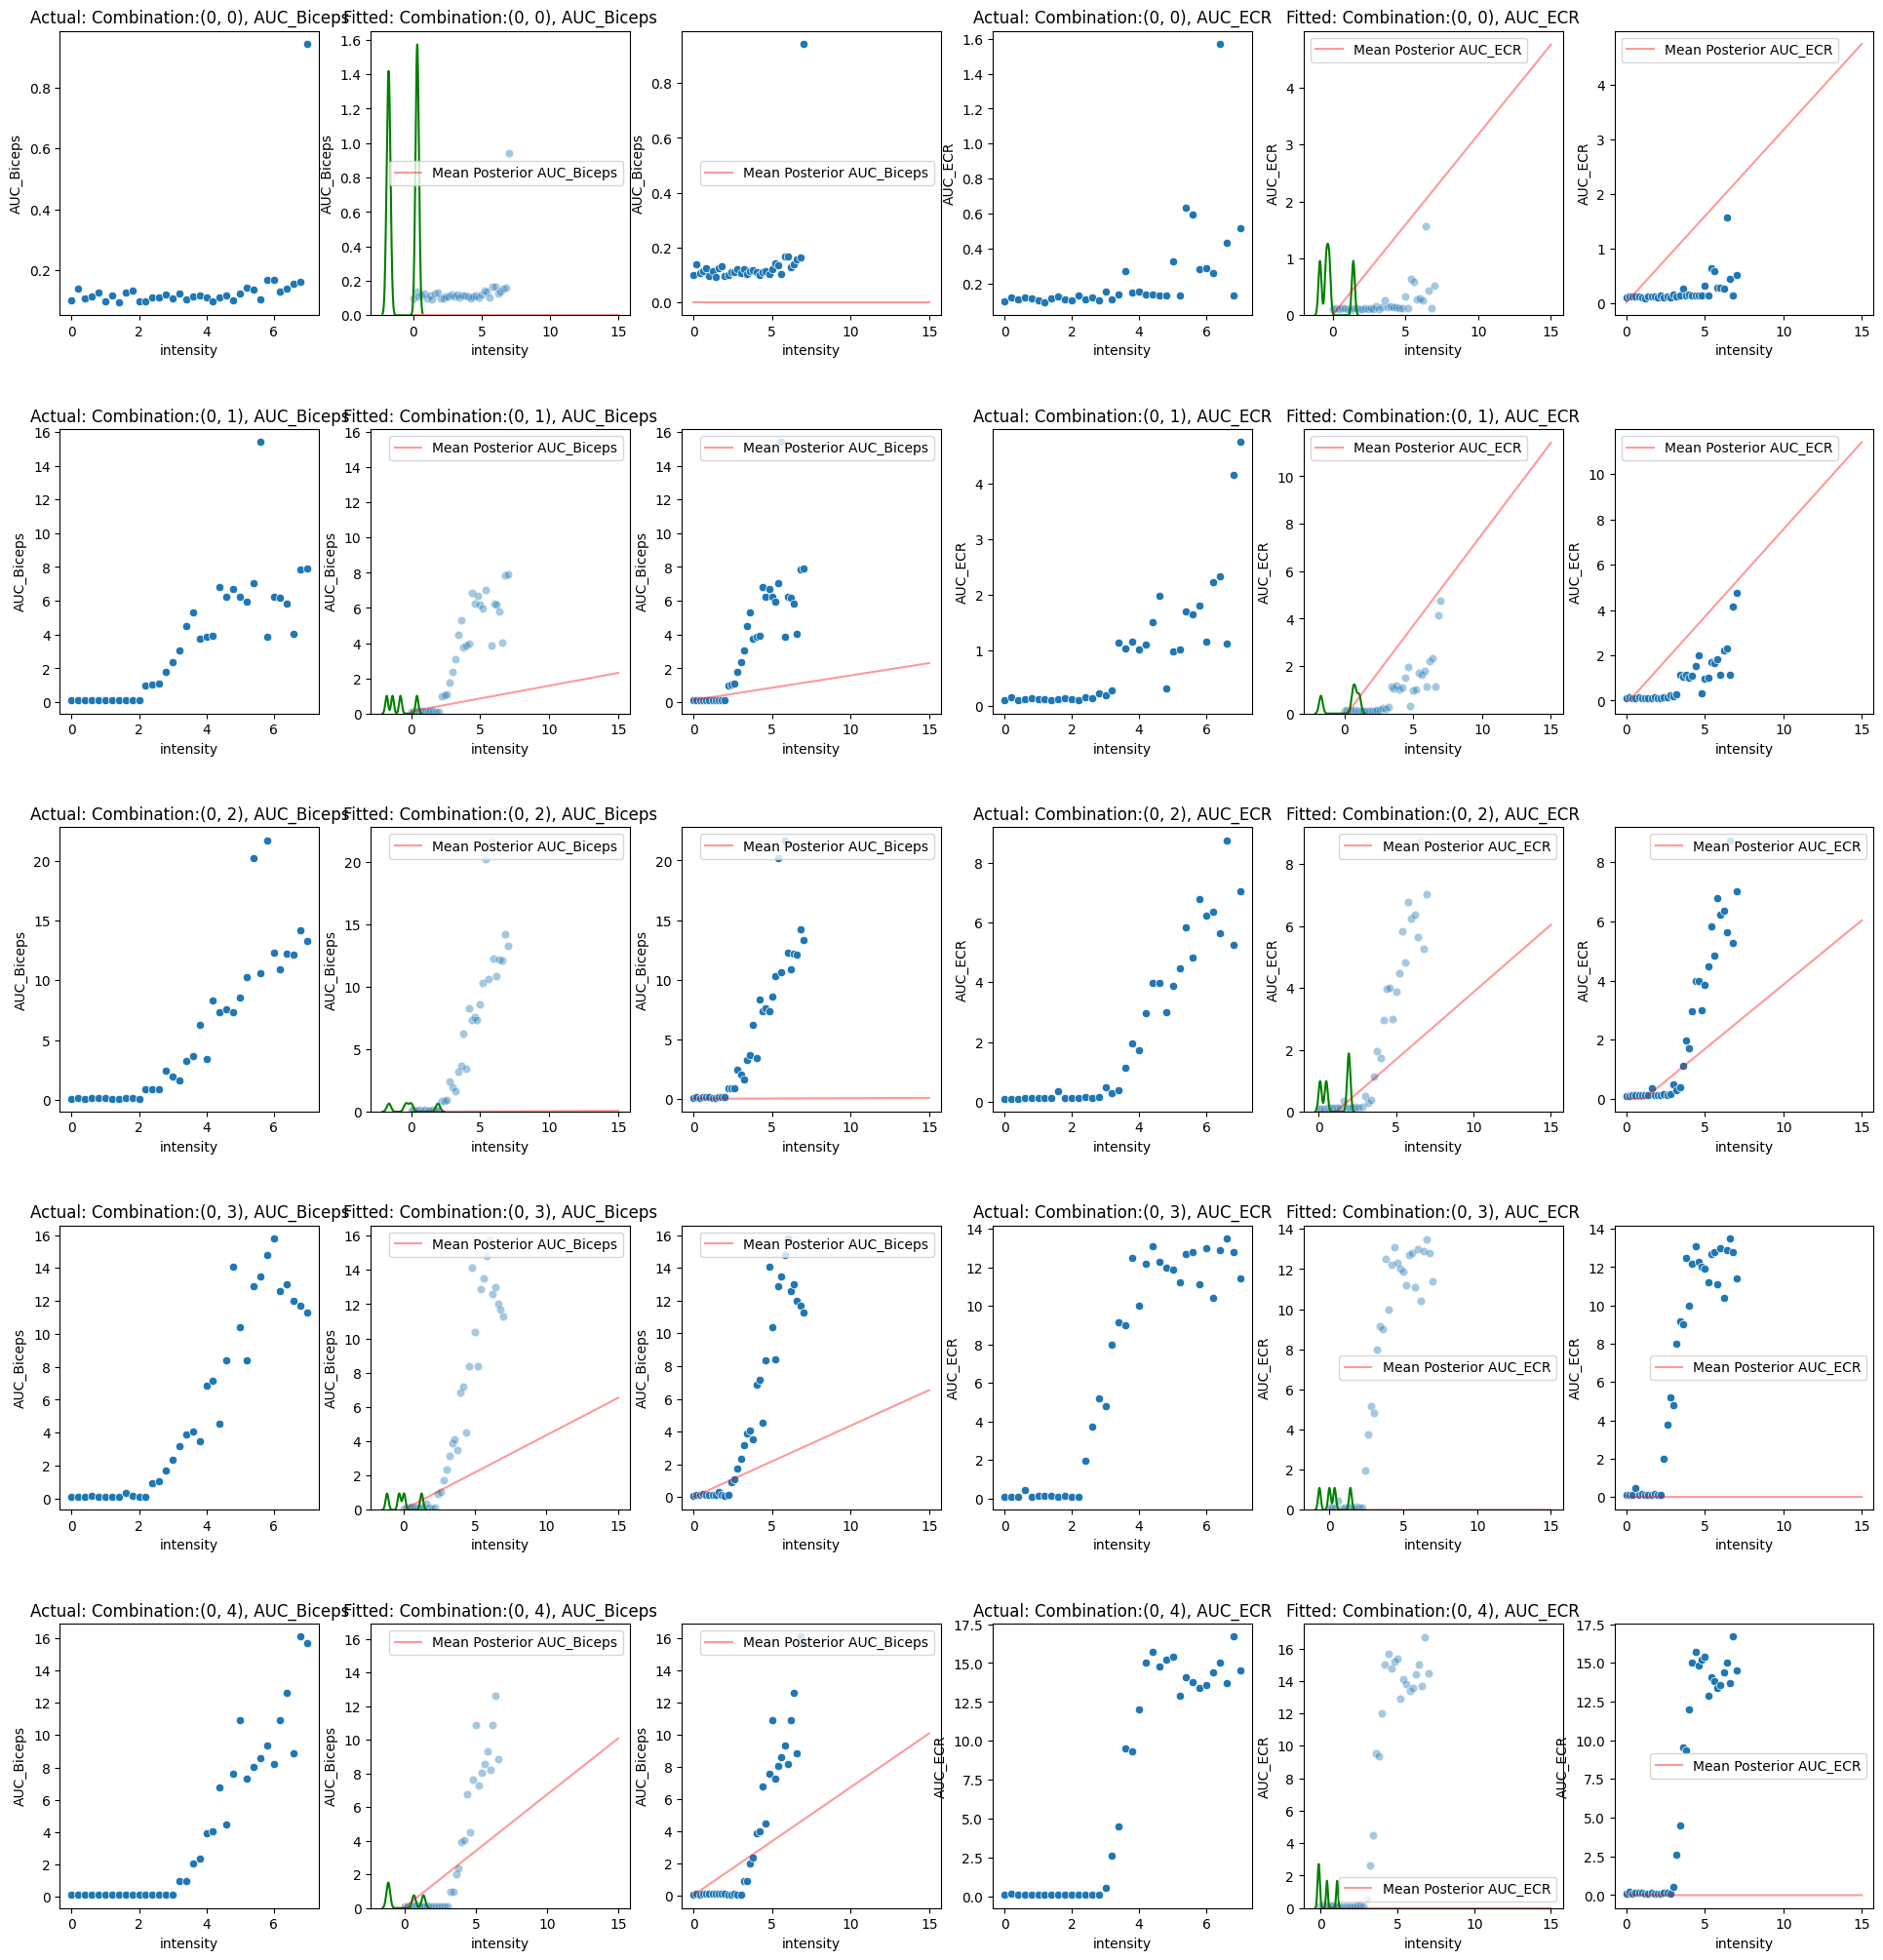

In [78]:
plot_fit(df, posterior_samples);

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_fit(
        df: pd.DataFrame,
        posterior_samples: dict
):
    n_muscles = 2

    combinations = \
        df \
        .groupby(by=[PARTICIPANT] + INDEPENDENT_FEATURES) \
        .size() \
        .to_frame('counts') \
        .reset_index().copy()
    combinations = combinations[[PARTICIPANT] + INDEPENDENT_FEATURES].apply(tuple, axis=1).tolist()
    total_combinations = len(combinations)

    fig, axes = plt.subplots(total_combinations, 3*n_muscles, figsize=(12*n_muscles,total_combinations*5))

    mean_a_Biceps = posterior_samples['a_Biceps'].mean(axis=0)
    mean_b_Biceps = posterior_samples['b_Biceps'].mean(axis=0)

    mean_a_ECR = posterior_samples['a_ECR'].mean(axis=0)
    mean_b_ECR = posterior_samples['b_ECR'].mean(axis=0)

    if 'lo' in posterior_samples:
        mean_lo = posterior_samples['lo'].mean(axis=0)

    if 'hi' in posterior_samples:
        mean_hi = posterior_samples['hi'].mean(axis=0)

    for i, c in enumerate(combinations):
        temp = \
            df[df[[PARTICIPANT] + INDEPENDENT_FEATURES] \
            .apply(tuple, axis=1) \
            .isin([c])] \
            .reset_index(drop=True) \
            .copy()

        a_Biceps = mean_a_Biceps[c[::-1]]
        b_Biceps = mean_b_Biceps[c[::-1]]

        a_ECR = mean_a_ECR[c[::-1]]
        b_ECR = mean_b_ECR[c[::-1]]

        if 'lo' in posterior_samples:
            lo = mean_lo[c[::-1]]

        if 'hi' in posterior_samples:
            hi = mean_hi[c[::-1]]

        axes[i, 0].set_title(f'Actual: Combination:{c}, {RESPONSE_MUSCLES[0]}')
        axes[i, 1].set_title(f'Fitted: Combination:{c}, {RESPONSE_MUSCLES[0]}')

        axes[i, 3].set_title(f'Actual: Combination:{c}, {RESPONSE_MUSCLES[1]}')
        axes[i, 4].set_title(f'Fitted: Combination:{c}, {RESPONSE_MUSCLES[1]}')

        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[0], ax=axes[i, 0])
        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[0], ax=axes[i, 1], alpha=.4)
        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[0], ax=axes[i, 2])

        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[1], ax=axes[i, 3])
        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[1], ax=axes[i, 4], alpha=.4)
        sns.scatterplot(data=temp, x=INTENSITY, y=RESPONSE_MUSCLES[1], ax=axes[i, 5])

        x_val = np.linspace(0, 15, 100)
        y_val_Biceps = jax.nn.relu(b_Biceps * (x_val - a_Biceps))
        y_val_ECR = jax.nn.relu(b_ECR * (x_val - a_ECR))

        if 'lo' in posterior_samples:
            y_val += lo

        sns.kdeplot(x=posterior_samples['a_Biceps'][:,c[-1],c[-2]], ax=axes[i, 1], color='green')
        sns.lineplot(
            x=x_val,
            y=y_val_Biceps,
            ax=axes[i, 1],
            color='red',
            alpha=0.4,
            label=f'Mean Posterior {RESPONSE_MUSCLES[0]}'
        )
        sns.lineplot(
            x=x_val,
            y=y_val_Biceps,
            ax=axes[i, 2],
            color='red',
            alpha=0.4,
            label=f'Mean Posterior {RESPONSE_MUSCLES[0]}'
        )

        sns.kdeplot(x=posterior_samples['a_ECR'][:,c[-1],c[-2]], ax=axes[i, 4], color='green')
        sns.lineplot(
            x=x_val,
            y=y_val_ECR,
            ax=axes[i, 4],
            color='red',
            alpha=0.4,
            label=f'Mean Posterior {RESPONSE_MUSCLES[1]}'
        )
        sns.lineplot(
            x=x_val,
            y=y_val_ECR,
            ax=axes[i, 5],
            color='red',
            alpha=0.4,
            label=f'Mean Posterior {RESPONSE_MUSCLES[1]}'
        )

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    return fig


In [ ]:



def model(intensity, participant, level, mep_size_obs=None):

    a_level_mean_global_scale = numpyro.sample('a_level_mean_global_scale', dist.HalfNormal(5.0*jnp.ones(4)))
    b_level_mean_global_scale = numpyro.sample('b_level_mean_global_scale', dist.HalfNormal(5.0*jnp.ones(4)))

    a_level_scale_global_scale = numpyro.sample('a_level_scale_global_scale', dist.HalfNormal(2.0*jnp.ones(4)))
    b_level_scale_global_scale = numpyro.sample('b_level_scale_global_scale', dist.HalfNormal(2.0*jnp.ones(4)))

    n_participants = np.unique(participant).shape[0]
    n_levels = np.unique(level).shape[0]

    with numpyro.plate("n_levels", n_levels, dim=-2):

        a_level_mean = numpyro.sample("a_level_mean", dist.HalfNormal(a_level_mean_global_scale)).reshape(n_levels, 1, 4)
        b_level_mean = numpyro.sample("b_level_mean", dist.HalfNormal(b_level_mean_global_scale)).reshape(n_levels, 1, 4)

        a_level_scale = numpyro.sample("a_level_scale", dist.HalfNormal(a_level_scale_global_scale))
        b_level_scale = numpyro.sample("b_level_scale", dist.HalfNormal(b_level_scale_global_scale))

        with numpyro.plate("n_participants", n_participants, dim=-1):
            a = numpyro.sample("a", dist.MultivariateNormal(a_level_mean, \
                jnp.tile(jax.vmap(jnp.diag)(a_level_scale)[:,jnp.newaxis,:,:], (1,18,1,1))))
            b = numpyro.sample("b", dist.MultivariateNormal(b_level_mean, \
                jnp.tile(jax.vmap(jnp.diag)(b_level_scale)[:,jnp.newaxis,:,:], (1,18,1,1))))

    sigma = numpyro.sample('sigma', dist.HalfCauchy(3*jnp.ones(4)))
    cov = jnp.diag(sigma)

    mean = jax.nn.relu(jnp.multiply(b[level, participant], jnp.tile(intensity, (4,1)).T - a[level, participant]))

    with numpyro.plate("data", len(intensity)):
        return numpyro.sample("obs", dist.MultivariateNormal(mean, jnp.diag(sigma)), obs=mep_size_obs)
        
numpyro.render_model(model, model_args=(intensity, participant, level, mep_size))

In [47]:
jnp.diag(3*jnp.ones(4))

Array([[3., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 3., 0.],
       [0., 0., 0., 3.]], dtype=float32)

In [21]:
jnp.diag(np.array([1, 2]))

(2, 2)

#### Initialize model

In [5]:
model = Baseline(config)

#### Run MCMC inference

In [6]:
mcmc, posterior_samples = model.sample(df=df)

2023-03-06 20:47:57,027 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-03-06 20:47:57,028 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-03-06 20:47:57,028 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-03-06 20:47:57,029 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-03-06 20:47:57,030 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-03-06 20:47:57,082 - hb_mep.models.baseline - INFO - Running inference wit

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

#### Diagnostics

In [7]:
mcmc.print_summary()


                                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                                 a[0,0]      6.81      0.04      6.79      6.76      6.89    171.25      1.01
                                 a[1,0]      1.93      0.06      1.95      1.84      2.02    815.40      1.00
                                 a[2,0]      2.03      0.03      2.03      1.98      2.08    637.07      1.01
                                 a[3,0]      2.22      0.04      2.22      2.16      2.29    132.70      1.03
                                 a[4,0]      3.02      0.02      3.02      2.99      3.05    152.12      1.03
                         a_global_scale      1.39      0.99      1.16      0.10      2.81    484.22      1.01
                      a_level_mean[0,0]      5.78      1.85      6.56      2.12      7.95    672.65      1.00
                      a_level_mean[1,0]      1.96      0.82      1.93      0.47      3.10   6802.46      1.00
         

#### Plot fitted curves

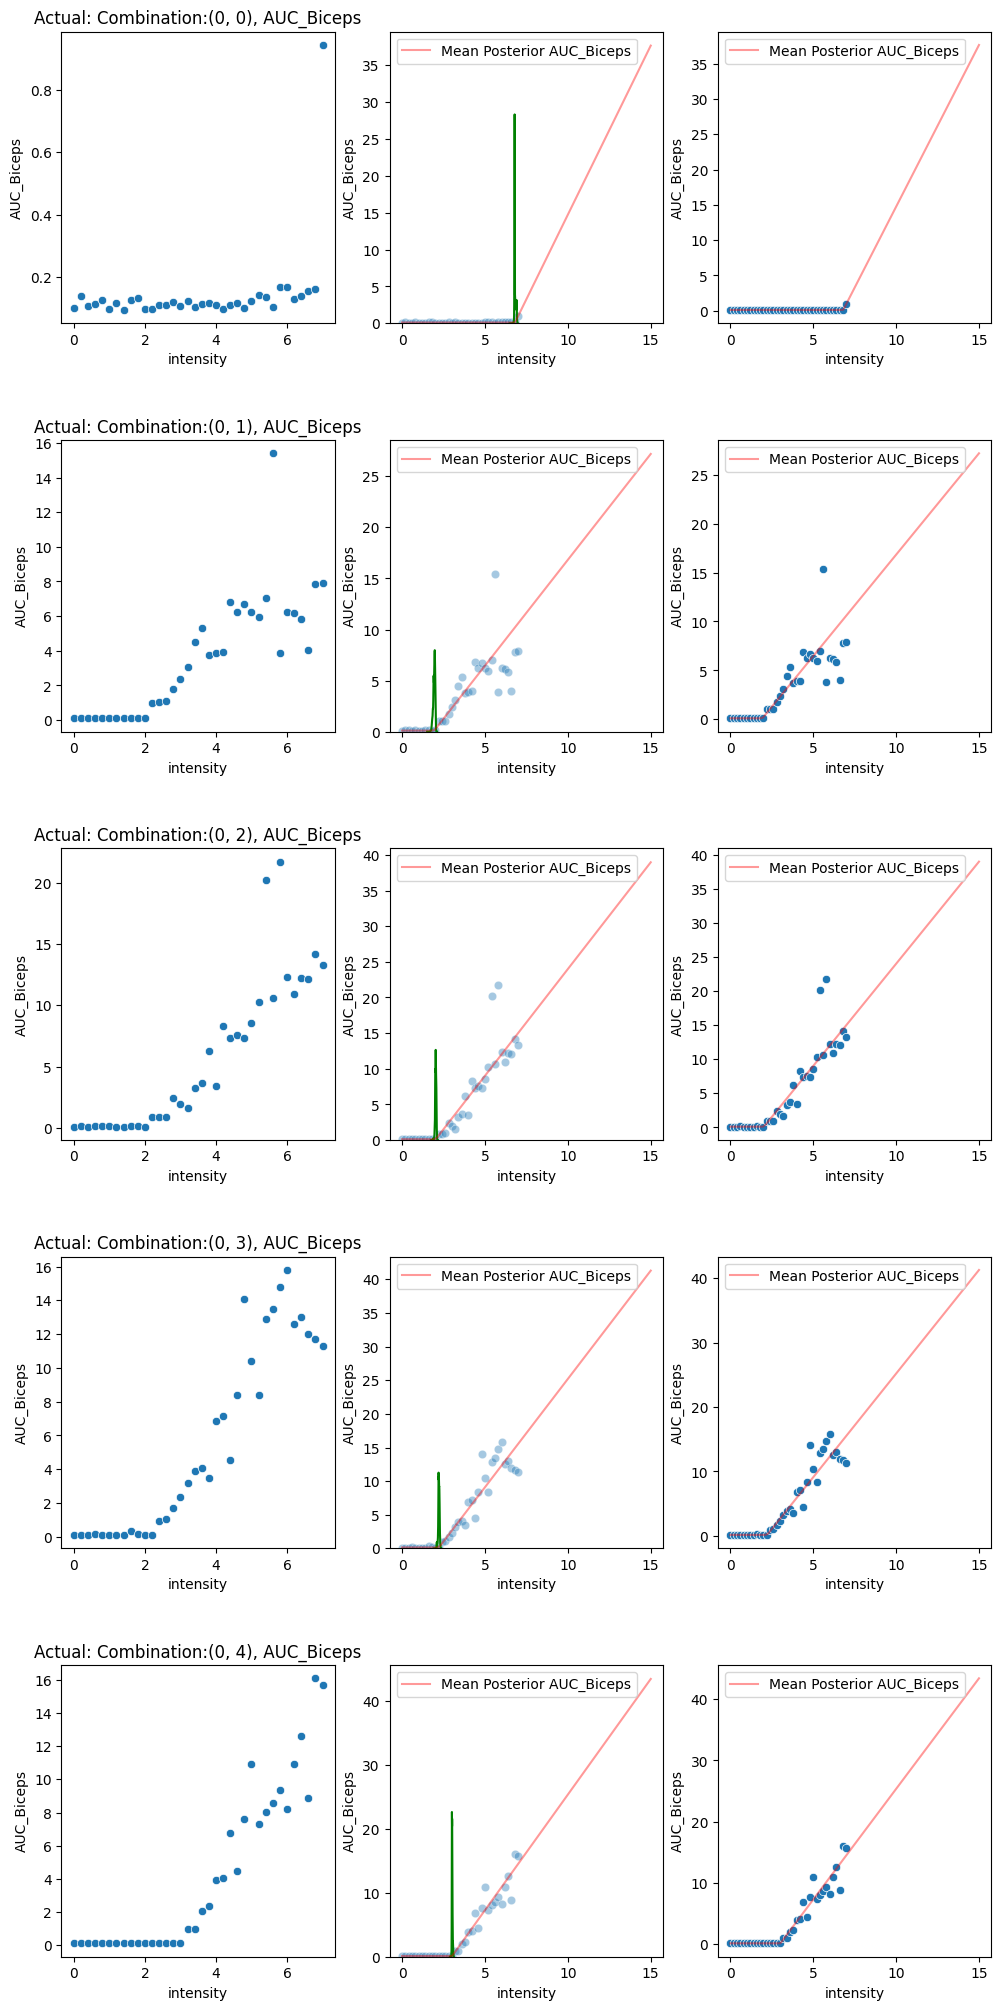

In [8]:
model.plot_fit(df=df, posterior_samples=posterior_samples);

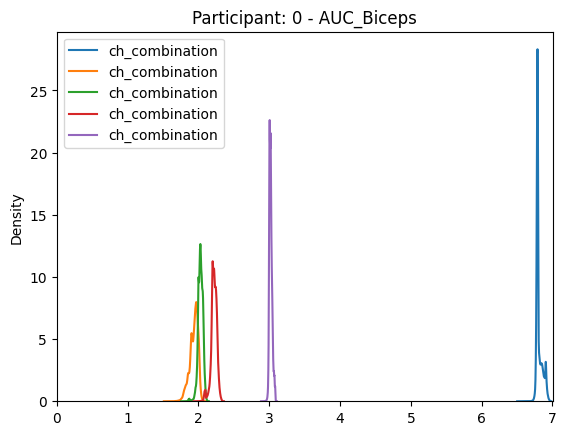

In [9]:
model.plot_kde(df=df, posterior_samples=posterior_samples);